# Data engineer skills Project

The objective of this project is to highlight the most in-demand skills for data engineer roles in France.

How it is done : 
1. Extract job postings for data engineer roles from a personal database.
2. Format description and look for most demanded skills.
3. Summarize the results visually.
4. Extract skils from courses syllabus. 

## Imports

In [142]:
import os
import numpy as np
import pandas as pd
import logging
from datetime import datetime
from sqlalchemy import create_engine, Table, MetaData, text
import re
import regex as re
import matplotlib.pyplot as plt
import pdfplumber

## Configuration

In [143]:
# Logging
LOG_DIR = "logs"
os.makedirs(LOG_DIR, exist_ok=True)
logging.basicConfig(
    filename=os.path.join(LOG_DIR, f"pipeline_{datetime.now().strftime('%Y-%m-%d')}.log"),
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

In [144]:
##################  VARIABLES  ##################
# Param Database PostgreSQL
DB_NAME = os.environ.get("DB_NAME", "jobsdb")
DB_USER = os.environ.get("DB_USER","jobsuser")
DB_PASS = os.environ.get("DB_PASS", "jobspass")
DB_HOST = os.environ.get("DB_HOST", "localhost")
DB_PORT = os.environ.get("DB_PORT","5432")

# Nom table
DB_TABLE_NAME = "offres_table"

## Extract data from database

In [145]:
### Connect to database
def export_from_database(engine, table_name):
    # logging.info("Connect to database.")
    try:  
        query = text(f"""
            SELECT     
                   id, 
                   source,
                   recherche,
                   titre,
                   description,
                   departement,
                   date_publication               
            FROM {table_name}
            WHERE recherche = 'data engineer'
        """)
        
        with engine.connect() as conn:
            result = conn.execute(query)       
            df_extract = pd.DataFrame(result.fetchall(),columns=["id", 
                                                               "source",
                                                               "recherche",
                                                               "titre",
                                                               "description",
                                                               "departement",
                                                               "date_publication"])    
            return df_extract
            
    except requests.RequestException as e:
        logging.error(f"Error database export: {e}")
        return []

In [146]:
# Connexion DB
engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

#Extract data from DB
df = export_from_database(engine, DB_TABLE_NAME)
# df = df.head(50)
display(df)

,id,source,recherche,titre,description,departement,date_publication
0,202FHJH,France Travail,data engineer,Knowledge Manager IA (H/F),CDI - Consultant Knowledge Manager IA (H/F)\n\...,91,2026-01-06
1,200MWYF,France Travail,data engineer,Ingénieur Gestion des Données Techniques (H/F),Rattaché au Responsable de Groupe Nouveaux Pro...,68,2025-11-19
2,7407914,France Travail,data engineer,Senior Consultant/Manager – Data Architect et/...,Description de l'entrepriseRejoignez un cabine...,92,2026-01-05
3,4882600908,Adzuna,data engineer,Data Engineer (H/F),Missions : Mise en place et la configuration d...,47,2024-10-01
4,8033210,France Travail,data engineer,Chef de projet DATA H/F,Mission principale : piloter la conception et ...,34,2026-01-19
...,...,...,...,...,...,...,...
4677,5558161529,Adzuna,data engineer,Lead Software Data Engineer – Data & AI Digita...,Wake IT UP recrute pour son client : client fi...,75,2025-12-28
4678,5395847606,Adzuna,data engineer,Data Engineer (Hadoop-Scala) Junior H/F (IT),Contexte et objectifs de la prestation : Le dé...,94,2025-09-12
4679,5558161326,Adzuna,data engineer,Data engineer Python GCP,Proxiad Ouest est à la recherche d’un nouveau ...,44,2025-12-28
4680,5504021111,Adzuna,data engineer,Data Engineer Python (IT),Mission : Data Engineer Python Localisation : ...,93,2025-11-19


## Clean and normalize job description

In [147]:
def clean_text(text):
    # logging.info("Clean and normalize job description.")
    try: 
        # Converts everything to lowercase
        text = text.lower()
    
        # It replaces anything like <tag>...</tag> with a space.
        text = re.sub(r"<.*?>", " ", text)     # HTML
    
        # Removes unwanted characters (but keeps French accents)
        # This line keeps only:
        # - lowercase letters a–z
        # - digits 0–9
        # - + . /
        # - spaces
        # Everything else becomes a space.
        text = re.sub(r"[^\p{L}0-9+./ ]", " ", text)
    
        # Cleans extra spaces
        # - \s+ = multiple spaces
        # - Replaces them with one single space
        # - .strip() removes spaces at the beginning and end
        text = re.sub(r"\s+", " ", text).strip()
        return text
    except requests.RequestException as e:
        logging.error(f"Error cleaning and normalizing process: {e}")
        return []

df["clean_description"] = df["description"].astype(str).apply(clean_text)

## Extract skills

In [148]:
DATA_ENGINEER_ONTOLOGY = {
    "Langages": [
        "python", "sql", "scala", "java", "bash"
    ],
    "Bases_de_donnees": [
        "postgresql", "mysql", "sql server", "oracle",
        "snowflake", "bigquery", "redshift", "synapse",
        "mongodb", "cassandra", "dynamodb", "elasticsearch"
    ],
    "Modelisation_et_architecture": [
        "data modeling", "dimensional modeling",
        "star schema", "snowflake schema",
        "data warehouse", "data lake", "lakehouse",
        "lambda architecture", "medallion architecture"
    ],
    "Pipelines_et_orchestration": [
        "etl", "elt", "data pipeline", "ingestion",
        "airflow", "dagster", "prefect"
    ],
    "Big_Data": [
        "spark", "pyspark", "hadoop",
        "distributed computing", "partitioning"
    ],
    "Streaming": [
        "kafka", "kinesis", "pubsub", "event streaming"
    ],
    "Cloud": [
        "aws", "gcp", "azure",
        "s3", "gcs", "adls",
        "glue", "dataproc", "databricks"
    ],
    "DevOps_DataOps": [
        "docker", "kubernetes", "ci/cd",
        "terraform", "infrastructure as code"
    ],
    "Qualite_et_gouvernance": [
        "data quality", "data validation", "monitoring",
        "data governance", "data lineage", "rgpd"
    ],
    "Analytics_enablement": [
        "dbt", "semantic layer",
        "power bi", "tableau", "looker"
    ]
}

In [149]:
def extract_skills(text, ontology):
    # logging.info("Extract skills from job description.")
    try:     
        found_skills = set()
        for category, skills in ontology.items():
            for skill in skills:
                if skill in text:
                    found_skills.add(skill)
        return list(found_skills)
    except requests.RequestException as e:
        logging.error(f"Error during extracting skills process: {e}")
        return []

df["skills_found"] = df["clean_description"].apply(lambda x: extract_skills(x, DATA_ENGINEER_ONTOLOGY))
df[["id", "skills_found"]].head()

,id,skills_found
0,202FHJH,[]
1,200MWYF,[]
2,7407914,"[gcp, aws, lakehouse, data lake, s3, azure]"
3,4882600908,[]
4,8033210,"[elt, snowflake, data lake, dbt, etl]"


In [150]:
# Long-form exploitation
skills_long = df.explode("skills_found")
skills_long = skills_long.dropna(subset=["skills_found"])

skills_long[["skills_found"]].head()

,skills_found
2,gcp
2,aws
2,lakehouse
2,data lake
2,s3


## Frequency statistics

In [151]:
# Count the total number of postings
total_offres = df["id"].nunique()
print(total_offres)

# Count the number of postings mentionning a specific skill
skills_stats = (
    skills_long.groupby("skills_found")["id"]
    .nunique()
    .reset_index()
    .rename(columns={"id": "nb_offres"})
)

# Compute the percentage of postings mentionning a specific skill
skills_stats["pourcentage"] = (skills_stats["nb_offres"] / total_offres * 100).round(1)
skills_stats = skills_stats.sort_values("pourcentage", ascending=False)
skills_stats.head(10)

4682


,skills_found,nb_offres,pourcentage
55,sql,772,16.5
47,python,684,14.6
51,scala,553,11.8
3,azure,513,11.0
54,spark,509,10.9
23,etl,460,9.8
24,gcp,453,9.7
2,aws,379,8.1
7,ci/cd,362,7.7
52,snowflake,355,7.6


## Visualization

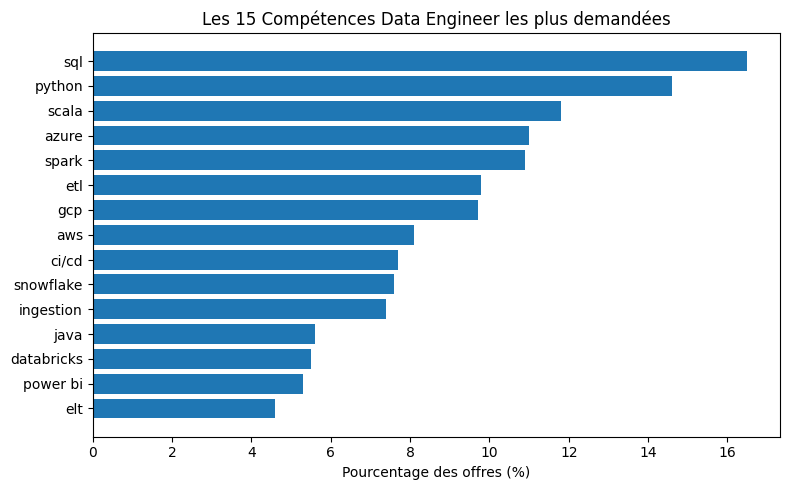

In [152]:
# Display the top n in-demand skills
top_n = 15

# Plot the percentage of job postings mentionning a specific skill
plt.figure(figsize=(8, 5))
plt.barh(
    skills_stats.head(top_n)["skills_found"],
    skills_stats.head(top_n)["pourcentage"]
)
plt.xlabel("Pourcentage des offres (%)")
plt.title(f"Les {top_n} Compétences Data Engineer les plus demandées")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Personal skills

In [153]:
all_values = [
    item
    for values in DATA_ENGINEER_ONTOLOGY.values()
    for item in values
]
all_values;

In [154]:
candidate_skills = {
                    'python' : "acquired",
                     'sql' : "acquired",
                     'scala' : "to be acquired",
                     'java' : "partially",
                     'bash' : "partially",
                     'postgresql' : "partially",
                     'mysql' : "partially",
                     'sql server' : "partially",
                     'oracle' : "to be acquired",
                     'snowflake' : "to be acquired",
                     'bigquery' : "partially",
                     'redshift': "to be acquired",
                     'synapse': "to be acquired",
                     'mongodb': "to be acquired",
                     'cassandra': "to be acquired",
                     'dynamodb': "to be acquired",
                     'elasticsearch': "to be acquired",
                     'data modeling': "acquired",
                     'dimensional modeling': "partially",
                     'star schema': "acquired",
                     'snowflake schema' : "acquired",
                     'data warehouse': "partially",
                     'data lake': "partially",
                     'lakehouse': "partially",
                     'lambda architecture': "to be acquired",
                     'medallion architecture': "to be acquired",
                     'etl': "partially",
                     'elt': "partially",
                     'data pipeline': "partially",
                     'ingestion': "to be acquired",
                     'airflow': "partially",
                     'dagster': "to be acquired",
                     'prefect': "partially",
                     'spark' : "to be acquired",
                     'pyspark': "to be acquired",
                     'hadoop': "to be acquired",
                     'distributed computing': "partially",
                     'partitioning': "partially",
                     'kafka': "to be acquired",
                     'kinesis': "to be acquired",
                     'pubsub': "to be acquired",
                     'event streaming': "to be acquired",
                     'aws': "to be acquired",
                     'gcp': "partially",
                     'azure': "partially",
                     's3': "to be acquired",    
                     'gcs': "to be acquired",
                     'adls': "to be acquired",
                     'glue': "to be acquired",
                     'dataproc': "to be acquired",
                     'databricks': "to be acquired",
                     'docker' : "partially",
                     'kubernetes': "to be acquired",
                     'ci/cd': "to be acquired",
                     'terraform': "to be acquired",
                     'infrastructure as code': "acquired",
                     'data quality': "partially",
                     'data validation': "acquired",
                     'monitoring': "partially",
                     'data governance': "partially",
                     'data lineage': "partially",
                     'rgpd': "partially",
                     'dbt': "to be acquired",
                     'semantic layer': "to be acquired",
                     'power bi': "acquired",
                     'tableau': "to be acquired",
                     'looker': "acquired"
}

df_candidat = pd.DataFrame.from_dict(candidate_skills, orient="index", columns=["level"]
                                    ).reset_index().rename(columns={"index": "skill"})
df_candidat.head()

,skill,level
0,python,acquired
1,sql,acquired
2,scala,to be acquired
3,java,partially
4,bash,partially


## Extract skills from syllabus

In [155]:
# Define features of different training courses
data_engineer_LeWagon = {
    "syllabus_path" : "../data/raw_data/Data Engineering Syllabus_FR.pdf",
    "name" : "Le Wagon",
    "skills" : []    
}

data_engineer_DataScientest = {
    "syllabus_path" : "../data/raw_data/FR_Syllabus+Data+Engineer_2023_051023.pdf",
    "name" : "Data Scientest",
    "skills" : []    
}

training_courses = [data_engineer_LeWagon,data_engineer_DataScientest]

In [156]:
# Function to rerieve, clean and normalize the syllabus text

def retrieve_syllabus_text(path):
    # Retrieve syllabus text
    with pdfplumber.open(path) as pdf:
        texte_complet = ""
        for page in pdf.pages:
            texte_complet += page.extract_text() or ""
    
    # Clean and normalize text
    texte_complet_clean = clean_text(texte_complet)
    
    return texte_complet_clean

In [157]:
def extract_skills_in_training(text, ontology):
    # logging.info("Extract skills from training courses.")
    try:     
        found_skills = []
        for category, skills in ontology.items():
            for skill in skills:
                if skill in text:
                    found_skills.append(skill)
        return found_skills
    except requests.RequestException as e:
        logging.error(f"Error during extracting skills process (training courses): {e}")
        return []

# Extract the skills taught in each training course
for course in training_courses:
    texte_complet_clean = retrieve_syllabus_text(course["syllabus_path"])
    course["skills"] = extract_skills_in_training(texte_complet_clean, DATA_ENGINEER_ONTOLOGY)

## Skills taught by the training courses

In [158]:
# Format the skills from training courses into a Pandas dataframe
formations = {
    training_courses[0]["name"]: training_courses[0]["skills"],
    training_courses[1]["name"]: training_courses[1]["skills"],
}

df_formations = pd.DataFrame.from_dict(formations, orient="index").transpose()
display(df_formations)

,Le Wagon,Data Scientest
0,python,python
1,sql,sql
2,postgresql,scala
3,bigquery,bash
4,data warehouse,mongodb
5,data lake,elasticsearch
6,etl,data pipeline
7,elt,airflow
8,data pipeline,spark
9,airflow,pyspark


In [159]:
# Merge in-demand skill with current candidate status
matrix = skills_stats.merge(df_candidat, left_on="skills_found", right_on="skill", how="left")
matrix = matrix.drop(columns=['skill'])

# Display most in-demand skills on job market and matching skills taught in training courses
for formation, skills in formations.items():
    matrix[formation] = matrix["skills_found"].apply(
        lambda x: "✓" if x in skills else ""
    )

matrix.head(15)

,skills_found,nb_offres,pourcentage,level,Le Wagon,Data Scientest
0,sql,772,16.5,acquired,✓,✓
1,python,684,14.6,acquired,✓,✓
2,scala,553,11.8,to be acquired,,✓
3,azure,513,11.0,partially,,✓
4,spark,509,10.9,to be acquired,✓,✓
5,etl,460,9.8,partially,✓,
6,gcp,453,9.7,partially,✓,
7,aws,379,8.1,to be acquired,,✓
8,ci/cd,362,7.7,to be acquired,✓,
9,snowflake,355,7.6,to be acquired,,
